Note : Please use **PyTorch 2.0 Python 3.10 GPU kernel on g4dn.xlarge** for this notebook

# https://github.com/kvablack/ddpo-pytorch
# ddpo-pytorch

This is an implementation of [Denoising Diffusion Policy Optimization (DDPO)](https://rl-diffusion.github.io/) in PyTorch with support for [low-rank adaptation (LoRA)](https://huggingface.co/docs/diffusers/training/lora). Unlike our original research code (which you can find [here](https://github.com/jannerm/ddpo)), this implementation runs on GPUs, and if LoRA is enabled, requires less than 10GB of GPU memory to finetune Stable Diffusion!

![DDPO](teaser.jpg)

## Installation
Requires Python 3.10 or newer.

```bash
git clone git@github.com:kvablack/ddpo-pytorch.git
cd ddpo-pytorch
pip install -e .
```

## Usage
```bash
accelerate launch scripts/train.py
```
This will immediately start finetuning Stable Diffusion v1.5 for compressibility on all available GPUs using the config from `config/base.py`. It should work as long as each GPU has at least 10GB of memory. If you don't want to log into wandb, you can run `wandb disabled` before the above command.

Please note that the default hyperparameters in `config/base.py` are not meant to achieve good performance, they are just to get the code up and running as fast as possible. I would not expect to get good results without using a much larger number of samples per epoch and gradient accumulation steps.

## Important Hyperparameters

A detailed explanation of all the hyperparameters can be found in `config/base.py`. Here are a few of the important ones.

### prompt_fn and reward_fn
At a high level, the problem of finetuning a diffusion model is defined by 2 things: a set of prompts to generate images, and a reward function to evaluate those images. The prompts are defined by a `prompt_fn` which takes no arguments and generates a random prompt each time it is called. The reward function is defined by a `reward_fn` which takes in a batch of images and returns a batch of rewards for those images. All of the prompt and reward functions currently implemented can be found in `ddpo_pytorch/prompts.py` and `ddpo_pytorch/rewards.py`, respectively.

### Batch Sizes and Accumulation Steps
Each DDPO epoch consists of generating a batch of images, computing their rewards, and then doing some training steps on those images. One important hyperparameter is the number of images generated per epoch; you want enough images to get a good estimate of the average reward and the policy gradient. Another important hyperparameter is the number of training steps per epoch.

However, these are not defined explicitly but are instead defined implicitly by several other hyperparameters. First note that all batch sizes are **per GPU**. Therefore, the total number of images generated per epoch is `sample.batch_size * num_gpus * sample.num_batches_per_epoch`. The effective total training batch size (if you include multi-GPU training and gradient accumulation) is `train.batch_size * num_gpus * train.gradient_accumulation_steps`. The number of training steps per epoch is the first number divided by the second number, or `(sample.batch_size * sample.num_batches_per_epoch) / (train.batch_size * train.gradient_accumulation_steps)`.

(This assumes that `train.num_inner_epochs == 1`. If this is set to a higher number, then training will loop over the same batch of images multiple times before generating a new batch of images, and the number of training steps per epoch will be multiplied accordingly.)

At the beginning of each training run, the script will print out the calculated value for the number of images generated per epoch, the effective total training batch size, and the number of training steps per epoch. Make sure to double-check these numbers!

## Reproducing Results
The image at the top of this README was generated using LoRA! However, I did use a fairly powerful DGX machine with 8xA100 GPUs, on which each experiment took about 4 hours for 100 epochs. In order to run the same experiments with a single small GPU, you would set `sample.batch_size = train.batch_size = 1` and multiply `sample.num_batches_per_epoch` and `train.gradient_accumulation_steps` accordingly.

You can find the exact configs I used for the 4 experiments in `config/dgx.py`. For example, to run the aesthetic quality experiment:
```bash
accelerate launch scripts/train.py --config config/dgx.py:aesthetic
```

If you want to run the LLaVA prompt-image alignment experiments, you need to dedicate a few GPUs to running LLaVA inference using [this repo](https://github.com/kvablack/LLaVA-server/).

## Reward Curves
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/593c9be3-e2a7-45d8-b1ae-ca4f77197c18" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/d12fef0a-68b8-4cef-a9b8-cb1b6878fcec" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/68c6a7ac-0c31-4de6-a7a0-1f9bb20202a4" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/393a929e-36af-46f2-8022-33384bdae1c8" width="49%">

As you can see with the aesthetic experiment, if you run for long enough the algorithm eventually experiences instability. This might be remedied by decaying the learning rate. Interestingly, however, the actual qualitative samples you get after the instability are mostly fine -- the drop in the mean is caused by a few low-scoring outliers. This is clear from the full reward histogram, which you can see if you go to an individual run in wandb.

<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/eda43bef-6363-45b5-829d-466502e0a0e3" width="50%">



# What's the use case?
In this lab we will generate synthetic satellite images. These images can be used for research or as input data for building your computer vision models.

# Stable Diffusion

## Why fine tune stable diffusion?

Although Stable diffusion is great at generating images, the quality of images that specialise in a particular are may not be great. For example, in this notebook we aim to generate satellite images. However, the default satellite images that are generated do show some of the features (such as highways) very well. To improve the quality of satellite images with highways, we fine-tune stable diffusion using real satellite images.

## How do we fine-tune

To fine-tune stable diffusion we use a method called DreamBooth which is described [here](https://dreambooth.github.io/). Here's a short description of dreambooth from the paper
> Our method takes as input a few images (typically 3-5 images suffice, based on our experiments) of a subject (e.g., a specific dog) and the corresponding class name (e.g. "dog"), and returns a fine-tuned/"personalized'' text-to-image model that encodes a unique identifier that refers to the subject. Then, at inference, we can implant the unique identifier in different sentences to synthesize the subjects in difference contexts.

**Lets Get started!**
The first step is to get a feel of the hardware. A reminder though, please make sure you have the right kernel and notebook size as specified at the top!



In [25]:
# !nvidia-smi

Wed Aug 23 05:02:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |   9987MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%pip install -U \
  ml-collections \
  absl-py \
  diffusers \
  torchvision \
  inflect==6.0.4 \
  pydantic==1.10.9 \
  transformers==4.30.2 \
  accelerate>=0.20.3 \
  ftfy \
  tensorboard \
  Jinja2


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install -e .

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///root/generative-ai-on-aws/11_control
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ddpo-pytorch

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
#!pip install -U transformers accelerate>=0.20.3 ftfy tensorboard Jinja2 #huggingface_hub #wandb #kaggle #git+https://github.com/huggingface/diffusers
# !pip install -U accelerate
# !pip install -U transformers


import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.30.2', '0.19.0')

Next, we install a few libraries that the notebook needs.

### Dataset
For this tutorial, we will use the EuroSAT dataset, which is a land use classification dataset consisting of Sentinel 2 Satellite images. We will use the `Highway` class as the type of satellite image that we would like to generate. The `Forest` and `Industrial` classes serve as the *class* that we want the model to separate the `Highway` *instance*. Note, for the purposes of this exercise, we will display all images resized to 64,64 to match the EuroSAT dataset image size.



## View Dataset
Let's view the `Highway` class of the EuroSAT dataset

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Let's view the `Forest` and `Industrial` classes:

Some preparatory stuff. Copy the files to a location that we can use during fine-tuning

## Images generated by Stable Diffusion
Before we start fine-tuning, lets have a look at the default images generated by Stable Diffusion. We use Stable Diffusion (1.5) to generate satellite images of the `Highway` class. 

We leverate the [Diffusers](https://huggingface.co/docs/diffusers/index) library from Huggingface for the generation.

In [ ]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


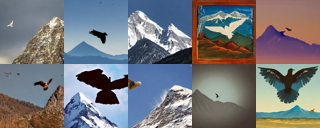

In [4]:
# images before fine tuning
img_list = pipe(["a mountain with a flying bird"]*10, num_inference_steps=25).images
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [6]:
# import gc
# from numba import cuda
# del(pipe)
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# https://godatadriven.com/blog/a-practical-guide-to-using-setup-py/
# run setup.py
# only run the first time
# !pip install -e .

## Actual highway class images from EuroSAT 

In [ ]:
# !accelerate launch scripts/train.py 

In [ ]:
from collections import defaultdict
import contextlib
import os
import datetime
from concurrent import futures
import time
from absl import app, flags
from ml_collections import config_flags
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration
from accelerate.logging import get_logger
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
import numpy as np
import ddpo_pytorch.prompts
import ddpo_pytorch.rewards
from ddpo_pytorch.stat_tracking import PerPromptStatTracker
from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob
import torch
import wandb
from functools import partial
import tqdm
import tempfile
from PIL import Image

tqdm = partial(tqdm.tqdm, dynamic_ncols=True)


FLAGS = flags.FLAGS
config_flags.DEFINE_config_file("config", "config/base.py", "Training configuration.")

logger = get_logger(__name__)

   

# basic Accelerate and logging setup
config = FLAGS.config

unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
if not config.run_name:
    config.run_name = unique_id
else:
    config.run_name += "_" + unique_id

if config.resume_from:
    config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
    if "checkpoint_" not in os.path.basename(config.resume_from):
        # get the most recent checkpoint in this directory
        checkpoints = list(filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from)))
        if len(checkpoints) == 0:
            raise ValueError(f"No checkpoints found in {config.resume_from}")
        config.resume_from = os.path.join(
            config.resume_from,
            sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
        )

# number of timesteps within each trajectory to train on
num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

accelerator_config = ProjectConfiguration(
    project_dir=os.path.join(config.logdir, config.run_name),
    automatic_checkpoint_naming=True,
    total_limit=config.num_checkpoint_limit,
)

accelerator = Accelerator(
    # log_with="wandb",
    mixed_precision=config.mixed_precision,
    project_config=accelerator_config,
    # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
    # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
    # the total number of optimizer steps to accumulate across.
    gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
)
if accelerator.is_main_process:
    accelerator.init_trackers(
        project_name="ddpo-pytorch", config=config.to_dict(), init_kwargs={"wandb": {"name": config.run_name}}
    )
logger.info(f"\n{config}")

# set seed (device_specific is very important to get different prompts on different devices)
set_seed(config.seed, device_specific=True)

# load scheduler, tokenizer and models.
pipeline = StableDiffusionPipeline.from_pretrained(config.pretrained.model, revision=config.pretrained.revision)
# freeze parameters of models to save more memory
pipeline.vae.requires_grad_(False)
pipeline.text_encoder.requires_grad_(False)
pipeline.unet.requires_grad_(not config.use_lora)
# disable safety checker
pipeline.safety_checker = None
# make the progress bar nicer
pipeline.set_progress_bar_config(
    position=1,
    disable=not accelerator.is_local_main_process,
    leave=False,
    desc="Timestep",
    dynamic_ncols=True,
)
# switch to DDIM scheduler
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
inference_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    inference_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    inference_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to inference_dtype
pipeline.vae.to(accelerator.device, dtype=inference_dtype)
pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
if config.use_lora:
    pipeline.unet.to(accelerator.device, dtype=inference_dtype)

if config.use_lora:
    # Set correct lora layers
    lora_attn_procs = {}
    for name in pipeline.unet.attn_processors.keys():
        cross_attention_dim = (
            None if name.endswith("attn1.processor") else pipeline.unet.config.cross_attention_dim
        )
        if name.startswith("mid_block"):
            hidden_size = pipeline.unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = pipeline.unet.config.block_out_channels[block_id]

        lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
    pipeline.unet.set_attn_processor(lora_attn_procs)
    trainable_layers = AttnProcsLayers(pipeline.unet.attn_processors)
else:
    trainable_layers = pipeline.unet

# set up diffusers-friendly checkpoint saving with Accelerate
def save_model_hook(models, weights, output_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        pipeline.unet.save_attn_procs(output_dir)
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        models[0].save_pretrained(os.path.join(output_dir, "unet"))
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    weights.pop()  # ensures that accelerate doesn't try to handle saving of the model

def load_model_hook(models, input_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        # pipeline.unet.load_attn_procs(input_dir)
        tmp_unet = UNet2DConditionModel.from_pretrained(
            config.pretrained.model, revision=config.pretrained.revision, subfolder="unet"
        )
        tmp_unet.load_attn_procs(input_dir)
        models[0].load_state_dict(AttnProcsLayers(tmp_unet.attn_processors).state_dict())
        del tmp_unet
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
        models[0].register_to_config(**load_model.config)
        models[0].load_state_dict(load_model.state_dict())
        del load_model
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    models.pop()  # ensures that accelerate doesn't try to handle loading of the model

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if config.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

# Initialize the optimizer
if config.train.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )

    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(
    trainable_layers.parameters(),
    lr=config.train.learning_rate,
    betas=(config.train.adam_beta1, config.train.adam_beta2),
    weight_decay=config.train.adam_weight_decay,
    eps=config.train.adam_epsilon,
)

# prepare prompt and reward fn
prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# generate negative prompt embeddings
neg_prompt_embed = pipeline.text_encoder(
    pipeline.tokenizer(
        [""],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=pipeline.tokenizer.model_max_length,
    ).input_ids.to(accelerator.device)
)[0]
sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# initialize stat tracker
if config.per_prompt_stat_tracking:
    stat_tracker = PerPromptStatTracker(
        config.per_prompt_stat_tracking.buffer_size,
        config.per_prompt_stat_tracking.min_count,
    )

# for some reason, autocast is necessary for non-lora training but for lora training it isn't necessary and it uses
# more memory
autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast

# Prepare everything with our `accelerator`.
trainable_layers, optimizer = accelerator.prepare(trainable_layers, optimizer)

# executor to perform callbacks asynchronously. this is beneficial for the llava callbacks which makes a request to a
# remote server running llava inference.
executor = futures.ThreadPoolExecutor(max_workers=2)

# Train!
samples_per_epoch = config.sample.batch_size * accelerator.num_processes * config.sample.num_batches_per_epoch
total_train_batch_size = (
    config.train.batch_size * accelerator.num_processes * config.train.gradient_accumulation_steps
)

logger.info("***** Running training *****")
logger.info(f"  Num Epochs = {config.num_epochs}")
logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
logger.info(f"  Train batch size per device = {config.train.batch_size}")
logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
logger.info("")
logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

assert config.sample.batch_size >= config.train.batch_size
assert config.sample.batch_size % config.train.batch_size == 0
assert samples_per_epoch % total_train_batch_size == 0

if config.resume_from:
    logger.info(f"Resuming from {config.resume_from}")
    accelerator.load_state(config.resume_from)
    first_epoch = int(config.resume_from.split("_")[-1]) + 1
else:
    first_epoch = 0

global_step = 0
for epoch in range(first_epoch, config.num_epochs):
    #################### SAMPLING ####################
    pipeline.unet.eval()
    samples = []
    prompts = []
    for i in tqdm(
        range(config.sample.num_batches_per_epoch),
        desc=f"Epoch {epoch}: sampling",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        # generate prompts
        prompts, prompt_metadata = zip(
            *[prompt_fn(**config.prompt_fn_kwargs) for _ in range(config.sample.batch_size)]
        )

        # encode prompts
        prompt_ids = pipeline.tokenizer(
            prompts,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=pipeline.tokenizer.model_max_length,
        ).input_ids.to(accelerator.device)
        prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

        # sample
        with autocast():
            images, _, latents, log_probs = pipeline_with_logprob(
                pipeline,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=sample_neg_prompt_embeds,
                num_inference_steps=config.sample.num_steps,
                guidance_scale=config.sample.guidance_scale,
                eta=config.sample.eta,
                output_type="pt",
            )

        latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, 4, 64, 64)
        log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
        timesteps = pipeline.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

        # compute rewards asynchronously
        rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
        # yield to to make sure reward computation starts
        time.sleep(0)

        samples.append(
            {
                "prompt_ids": prompt_ids,
                "prompt_embeds": prompt_embeds,
                "timesteps": timesteps,
                "latents": latents[:, :-1],  # each entry is the latent before timestep t
                "next_latents": latents[:, 1:],  # each entry is the latent after timestep t
                "log_probs": log_probs,
                "rewards": rewards,
            }
        )

    # wait for all rewards to be computed
    for sample in tqdm(
        samples,
        desc="Waiting for rewards",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        rewards, reward_metadata = sample["rewards"].result()
        # accelerator.print(reward_metadata)
        sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)

    # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
    samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

    # gather rewards across processes
    rewards = accelerator.gather(samples["rewards"]).cpu().numpy()

    # log rewards and images
    accelerator.log(
        {"reward": rewards, "epoch": epoch, "reward_mean": rewards.mean(), "reward_std": rewards.std()},
        step=global_step,
    )

    # print out 
    print("reward = " + str(rewards))
    print("epoch = " + str(epoch))

    # this is a hack to force wandb to log the images as JPEGs instead of PNGs
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, image in enumerate(images):
            pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
            pil = pil.resize((256, 256))
            pil.save(os.path.join(tmpdir, f"{i}.jpg"))
        accelerator.log(
            {
                "images": [
                    wandb.Image(os.path.join(tmpdir, f"{i}.jpg"), caption=f"{prompt:.25} | {reward:.2f}")
                    for i, (prompt, reward) in enumerate(zip(prompts, rewards))
                ],
            },
            step=global_step,
        )

    # per-prompt mean/std tracking
    if config.per_prompt_stat_tracking:
        # gather the prompts across processes
        prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
        prompts = pipeline.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
        advantages = stat_tracker.update(prompts, rewards)
    else:
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

    # ungather advantages; we only need to keep the entries corresponding to the samples on this process
    samples["advantages"] = (
        torch.as_tensor(advantages)
        .reshape(accelerator.num_processes, -1)[accelerator.process_index]
        .to(accelerator.device)
    )

    del samples["rewards"]
    del samples["prompt_ids"]

    total_batch_size, num_timesteps = samples["timesteps"].shape
    assert total_batch_size == config.sample.batch_size * config.sample.num_batches_per_epoch
    assert num_timesteps == config.sample.num_steps

    #################### TRAINING ####################
    for inner_epoch in range(config.train.num_inner_epochs):
        # shuffle samples along batch dimension
        perm = torch.randperm(total_batch_size, device=accelerator.device)
        samples = {k: v[perm] for k, v in samples.items()}

        # shuffle along time dimension independently for each sample
        perms = torch.stack(
            [torch.randperm(num_timesteps, device=accelerator.device) for _ in range(total_batch_size)]
        )
        for key in ["timesteps", "latents", "next_latents", "log_probs"]:
            samples[key] = samples[key][torch.arange(total_batch_size, device=accelerator.device)[:, None], perms]

        # rebatch for training
        samples_batched = {k: v.reshape(-1, config.train.batch_size, *v.shape[1:]) for k, v in samples.items()}

        # dict of lists -> list of dicts for easier iteration
        samples_batched = [dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())]

        # train
        pipeline.unet.train()
        info = defaultdict(list)
        for i, sample in tqdm(
            list(enumerate(samples_batched)),
            desc=f"Epoch {epoch}.{inner_epoch}: training",
            position=0,
            disable=not accelerator.is_local_main_process,
        ):
            if config.train.cfg:
                # concat negative prompts to sample prompts to avoid two forward passes
                embeds = torch.cat([train_neg_prompt_embeds, sample["prompt_embeds"]])
            else:
                embeds = sample["prompt_embeds"]

            for j in tqdm(
                range(num_train_timesteps),
                desc="Timestep",
                position=1,
                leave=False,
                disable=not accelerator.is_local_main_process,
            ):
                with accelerator.accumulate(pipeline.unet):
                    with autocast():
                        if config.train.cfg:
                            noise_pred = pipeline.unet(
                                torch.cat([sample["latents"][:, j]] * 2),
                                torch.cat([sample["timesteps"][:, j]] * 2),
                                embeds,
                            ).sample
                            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                            noise_pred = noise_pred_uncond + config.sample.guidance_scale * (
                                noise_pred_text - noise_pred_uncond
                            )
                        else:
                            noise_pred = pipeline.unet(
                                sample["latents"][:, j], sample["timesteps"][:, j], embeds
                            ).sample
                        # compute the log prob of next_latents given latents under the current model
                        _, log_prob = ddim_step_with_logprob(
                            pipeline.scheduler,
                            noise_pred,
                            sample["timesteps"][:, j],
                            sample["latents"][:, j],
                            eta=config.sample.eta,
                            prev_sample=sample["next_latents"][:, j],
                        )

                    # ppo logic
                    advantages = torch.clamp(
                        sample["advantages"], -config.train.adv_clip_max, config.train.adv_clip_max
                    )
                    ratio = torch.exp(log_prob - sample["log_probs"][:, j])
                    unclipped_loss = -advantages * ratio
                    clipped_loss = -advantages * torch.clamp(
                        ratio, 1.0 - config.train.clip_range, 1.0 + config.train.clip_range
                    )
                    loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

                    # debugging values
                    # John Schulman says that (ratio - 1) - log(ratio) is a better
                    # estimator, but most existing code uses this so...
                    # http://joschu.net/blog/kl-approx.html
                    info["approx_kl"].append(0.5 * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2))
                    info["clipfrac"].append(torch.mean((torch.abs(ratio - 1.0) > config.train.clip_range).float()))
                    info["loss"].append(loss)

                    # backward pass
                    accelerator.backward(loss)
                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(trainable_layers.parameters(), config.train.max_grad_norm)
                    optimizer.step()
                    optimizer.zero_grad()

                # Checks if the accelerator has performed an optimization step behind the scenes
                if accelerator.sync_gradients:
                    assert (j == num_train_timesteps - 1) and (
                        i + 1
                    ) % config.train.gradient_accumulation_steps == 0
                    # log training-related stuff
                    info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
                    info = accelerator.reduce(info, reduction="mean")
                    info.update({"epoch": epoch, "inner_epoch": inner_epoch})
                    accelerator.log(info, step=global_step)
                    global_step += 1
                    info = defaultdict(list)

        # make sure we did an optimization step at the end of the inner epoch
        assert accelerator.sync_gradients

    if epoch > 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
        accelerator.save_state()

# follow save_model_hook() to save only lora weights that are updatd
output_dir = os.path.join(config.out_dir, config.run_name)
if config.use_lora:
    pipeline.unet.save_attn_procs(output_dir)
elif not config.use_lora:    
    pipeline.save_pretrained(output_dir, variant="fp16")
else: 
    raise ValueError(f"Unknown model type to save.")


In [ ]:
# from collections import defaultdict
# import contextlib
# import os
# import datetime
# from concurrent import futures
# import time
# from absl import app, flags
# from ml_collections import config_flags
# from accelerate import Accelerator
# from accelerate.utils import set_seed, ProjectConfiguration
# from accelerate.logging import get_logger
# from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
# from diffusers.loaders import AttnProcsLayers
# from diffusers.models.attention_processor import LoRAAttnProcessor
# import numpy as np
# import ddpo_pytorch.prompts
# import ddpo_pytorch.rewards
# from ddpo_pytorch.stat_tracking import PerPromptStatTracker
# from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
# from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob
# import torch
# import wandb
# from functools import partial
# import tqdm
# import tempfile
# from PIL import Image
# import boto3
# import json

# tqdm = partial(tqdm.tqdm, dynamic_ncols=True)


# FLAGS = flags.FLAGS
# config_flags.DEFINE_config_file("config", "config/base.py", "Training configuration.")

# logger = get_logger(__name__)

   
# # basic Accelerate and logging setup
# config = FLAGS.config

# unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
# if not config.run_name:
#     config.run_name = unique_id
# else:
#     config.run_name += "_" + unique_id

# if config.resume_from:
#     config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
#     if "checkpoint_" not in os.path.basename(config.resume_from):
#         # get the most recent checkpoint in this directory
#         checkpoints = list(filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from)))
#         if len(checkpoints) == 0:
#             raise ValueError(f"No checkpoints found in {config.resume_from}")
#         config.resume_from = os.path.join(
#             config.resume_from,
#             sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
#         )

# # number of timesteps within each trajectory to train on
# num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

# accelerator_config = ProjectConfiguration(
#     project_dir=os.path.join(config.logdir, config.run_name),
#     automatic_checkpoint_naming=True,
#     total_limit=config.num_checkpoint_limit,
# )

# accelerator = Accelerator(
#     # log_with="wandb",
#     mixed_precision=config.mixed_precision,
#     project_config=accelerator_config,
#     # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
#     # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
#     # the total number of optimizer steps to accumulate across.
#     gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
# )
# if accelerator.is_main_process:
#     accelerator.init_trackers(
#         project_name="ddpo-pytorch", config=config.to_dict(), init_kwargs={"wandb": {"name": config.run_name}}
#     )
# logger.info(f"\n{config}")

# # set seed (device_specific is very important to get different prompts on different devices)
# set_seed(config.seed, device_specific=True)

# # load scheduler, tokenizer and models.
# pipeline = StableDiffusionPipeline.from_pretrained(config.pretrained.model, revision=config.pretrained.revision)
# # freeze parameters of models to save more memory
# pipeline.vae.requires_grad_(False)
# pipeline.text_encoder.requires_grad_(False)
# pipeline.unet.requires_grad_(not config.use_lora)
# # disable safety checker
# pipeline.safety_checker = None
# # make the progress bar nicer
# pipeline.set_progress_bar_config(
#     position=1,
#     disable=not accelerator.is_local_main_process,
#     leave=False,
#     desc="Timestep",
#     dynamic_ncols=True,
# )
# # switch to DDIM scheduler
# pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# # For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# # as these weights are only used for inference, keeping weights in full precision is not required.
# inference_dtype = torch.float32
# if accelerator.mixed_precision == "fp16":
#     inference_dtype = torch.float16
# elif accelerator.mixed_precision == "bf16":
#     inference_dtype = torch.bfloat16

# # Move unet, vae and text_encoder to device and cast to inference_dtype
# pipeline.vae.to(accelerator.device, dtype=inference_dtype)
# pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
# if config.use_lora:
#     pipeline.unet.to(accelerator.device, dtype=inference_dtype)

# if config.use_lora:
#     # Set correct lora layers
#     lora_attn_procs = {}
#     for name in pipeline.unet.attn_processors.keys():
#         cross_attention_dim = (
#             None if name.endswith("attn1.processor") else pipeline.unet.config.cross_attention_dim
#         )
#         if name.startswith("mid_block"):
#             hidden_size = pipeline.unet.config.block_out_channels[-1]
#         elif name.startswith("up_blocks"):
#             block_id = int(name[len("up_blocks.")])
#             hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[block_id]
#         elif name.startswith("down_blocks"):
#             block_id = int(name[len("down_blocks.")])
#             hidden_size = pipeline.unet.config.block_out_channels[block_id]

#         lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
#     pipeline.unet.set_attn_processor(lora_attn_procs)
#     trainable_layers = AttnProcsLayers(pipeline.unet.attn_processors)
# else:
#     trainable_layers = pipeline.unet

# # set up diffusers-friendly checkpoint saving with Accelerate
# def save_model_hook(models, weights, output_dir):
#     assert len(models) == 1
#     if config.use_lora and isinstance(models[0], AttnProcsLayers):
#         pipeline.unet.save_attn_procs(output_dir)
#     elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
#         models[0].save_pretrained(os.path.join(output_dir, "unet"))
#     else:
#         raise ValueError(f"Unknown model type {type(models[0])}")
#     weights.pop()  # ensures that accelerate doesn't try to handle saving of the model

# def load_model_hook(models, input_dir):
#     assert len(models) == 1
#     if config.use_lora and isinstance(models[0], AttnProcsLayers):
#         # pipeline.unet.load_attn_procs(input_dir)
#         tmp_unet = UNet2DConditionModel.from_pretrained(
#             config.pretrained.model, revision=config.pretrained.revision, subfolder="unet"
#         )
#         tmp_unet.load_attn_procs(input_dir)
#         models[0].load_state_dict(AttnProcsLayers(tmp_unet.attn_processors).state_dict())
#         del tmp_unet
#     elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
#         load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
#         models[0].register_to_config(**load_model.config)
#         models[0].load_state_dict(load_model.state_dict())
#         del load_model
#     else:
#         raise ValueError(f"Unknown model type {type(models[0])}")
#     models.pop()  # ensures that accelerate doesn't try to handle loading of the model

# accelerator.register_save_state_pre_hook(save_model_hook)
# accelerator.register_load_state_pre_hook(load_model_hook)

# # Enable TF32 for faster training on Ampere GPUs,
# # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
# if config.allow_tf32:
#     torch.backends.cuda.matmul.allow_tf32 = True

# # Initialize the optimizer
# if config.train.use_8bit_adam:
#     try:
#         import bitsandbytes as bnb
#     except ImportError:
#         raise ImportError(
#             "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
#         )

#     optimizer_cls = bnb.optim.AdamW8bit
# else:
#     optimizer_cls = torch.optim.AdamW

# optimizer = optimizer_cls(
#     trainable_layers.parameters(),
#     lr=config.train.learning_rate,
#     betas=(config.train.adam_beta1, config.train.adam_beta2),
#     weight_decay=config.train.adam_weight_decay,
#     eps=config.train.adam_epsilon,
# )

# # prepare prompt and reward fn
# prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
# reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# # generate negative prompt embeddings
# neg_prompt_embed = pipeline.text_encoder(
#     pipeline.tokenizer(
#         [""],
#         return_tensors="pt",
#         padding="max_length",
#         truncation=True,
#         max_length=pipeline.tokenizer.model_max_length,
#     ).input_ids.to(accelerator.device)
# )[0]
# sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
# train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# # initialize stat tracker
# if config.per_prompt_stat_tracking:
#     stat_tracker = PerPromptStatTracker(
#         config.per_prompt_stat_tracking.buffer_size,
#         config.per_prompt_stat_tracking.min_count,
#     )

# # for some reason, autocast is necessary for non-lora training but for lora training it isn't necessary and it uses
# # more memory
# autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast

# # Prepare everything with our `accelerator`.
# trainable_layers, optimizer = accelerator.prepare(trainable_layers, optimizer)

# # executor to perform callbacks asynchronously. this is beneficial for the llava callbacks which makes a request to a
# # remote server running llava inference.
# executor = futures.ThreadPoolExecutor(max_workers=2)

# # Train!
# samples_per_epoch = config.sample.batch_size * accelerator.num_processes * config.sample.num_batches_per_epoch
# total_train_batch_size = (
#     config.train.batch_size * accelerator.num_processes * config.train.gradient_accumulation_steps
# )

# logger.info("***** Running training *****")
# logger.info(f"  Num Epochs = {config.num_epochs}")
# logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
# logger.info(f"  Train batch size per device = {config.train.batch_size}")
# logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
# logger.info("")
# logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
# logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
# logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
# logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

# assert config.sample.batch_size >= config.train.batch_size
# assert config.sample.batch_size % config.train.batch_size == 0
# assert samples_per_epoch % total_train_batch_size == 0

# if config.resume_from:
#     logger.info(f"Resuming from {config.resume_from}")
#     accelerator.load_state(config.resume_from)
#     first_epoch = int(config.resume_from.split("_")[-1]) + 1
# else:
#     first_epoch = 0

# sns_topic_arn = config.sns_topic_arn
# sns_client = boto3.client('sns')

# reward_sqs_name = config.sqs_name 
# sqs_region = config.sqs_region
# sqs_client = boto3.client('sqs', region_name=sqs_region)
# sqs_client.create_queue(QueueName=reward_sqs_name)
# sqs_obj = boto3.resource('sqs', region_name=sqs_region)
# sqs_queue = sqs_obj.get_queue_by_name(QueueName=reward_sqs_name)
# sqs_url = sqs_client.get_queue_url(QueueName=reward_sqs_name)['QueueUrl']

# global_step = 0
# image_global_order = 0  # use to map rewards to corresponding images
# for epoch in range(first_epoch, config.num_epochs):
#     #################### SAMPLING ####################
#     pipeline.unet.eval()
#     samples = []
#     prompts = []
#     for i in tqdm(
#         range(config.sample.num_batches_per_epoch),
#         desc=f"Epoch {epoch}: sampling",
#         disable=not accelerator.is_local_main_process,
#         position=0,
#     ):
#         # generate prompts
#         prompts, prompt_metadata = zip(
#             *[prompt_fn(**config.prompt_fn_kwargs) for _ in range(config.sample.batch_size)]
#         )

#         # encode prompts
#         prompt_ids = pipeline.tokenizer(
#             prompts,
#             return_tensors="pt",
#             padding="max_length",
#             truncation=True,
#             max_length=pipeline.tokenizer.model_max_length,
#         ).input_ids.to(accelerator.device)
#         prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

#         # sample
#         with autocast():
#             images, _, latents, log_probs = pipeline_with_logprob(
#                 pipeline,
#                 prompt_embeds=prompt_embeds,
#                 negative_prompt_embeds=sample_neg_prompt_embeds,
#                 num_inference_steps=config.sample.num_steps,
#                 guidance_scale=config.sample.guidance_scale,
#                 eta=config.sample.eta,
#                 output_type="pt",
#             )

#         latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, 4, 64, 64)
#         log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
#         timesteps = pipeline.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

# #             #########################################################################
#         # compute rewards asynchronously
#         # rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
#         # # yield to to make sure reward computation starts
#         # time.sleep(0)
# #             ##########################################################################

#         samples.append(
#             {
#                 "prompt_ids": prompt_ids,
#                 "prompt_embeds": prompt_embeds,
#                 "timesteps": timesteps,
#                 "latents": latents[:, :-1],  # each entry is the latent before timestep t
#                 "next_latents": latents[:, 1:],  # each entry is the latent after timestep t
#                 "log_probs": log_probs,
#                 # "rewards": rewards # important to update rewards later
#             }
#         )

#         # save image to a directory 
#         images_dir = config.image_dir
#         for image_index, image in enumerate(images):
#             pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
#             pil = pil.resize((256, 256))
#             # i = batch 
#             pil.save(os.path.join(images_dir, f"{image_global_order}_{epoch}.{i}.{image_index}.jpg"))
#             print("\nsaved image: " + f"{image_global_order}_{epoch}.{i}.{image_index}.jpg" + "\n") 
#             image_global_order = image_global_order + 1

#         # print("\nlen(images) = " + str(len(images)) + "\n")

#     ####################### Ground Truth Rewards #########################

#     # send sns nodifications for reward labelling
#     message = "Label rewards at epoch = " + str(epoch)   
#     msg_body = json.dumps(message)

#     sns_client.publish(
#             TopicArn=sns_topic_arn, 
#             Message=json.dumps({'default': msg_body}),
#             MessageStructure='json')
#     print("\nSNS published message: " + str(message))

#     # loop to wait sqs messages for returnning rewards
#     rewards_gt = None
#     loop = True
#     while (loop):
#             sqs_msgs = sqs_queue.receive_messages(
#                                 AttributeNames=['All'],
#                                 MessageAttributeNames=['All'],
#                                 VisibilityTimeout=15,
#                                 WaitTimeSeconds=20,
#                                 MaxNumberOfMessages=5
#                         )

#             if len(sqs_msgs)>0:
#                 loop = False
#                 for msg in sqs_msgs:
#                     msg_body = msg.body
#                     rewards_gt = json.loads(msg_body)
#                     print("\nReceive SQS message with labelled rewards: " + str(rewards_gt) + "\n")

#                 # delete the received messages
#                 for msg in sqs_msgs:
#                     sqs_client.delete_message(QueueUrl=sqs_url,
#                                               ReceiptHandle=msg.receipt_handle)
#             else:
#                 time.sleep(10)   

#     # print("rewards_gt = " + str(rewards_gt))

# #         # wait for all rewards to be computed
#     # for sample in tqdm(
#     #     samples,
#     #     desc="Waiting for rewards",
#     #     disable=not accelerator.is_local_main_process,
#     #     position=0,
#     # ):
#     #     rewards, reward_metadata = sample["rewards"].result()
#     #     # accelerator.print(reward_metadata)
#     #     sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)
#     #     # rewards is a numpy array
#     #     print("\n1: rewards = " + str(rewards))

#     # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
#     # for example, 2 samples, len(samples) == 2, where each sample has 7 key-value pairs
#     # is converted to 7 keys where each sample is a value
#     samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

#     # map ground truth rewards to samples, sample["rewards"]
#     rewards = rewards_gt

# #         # gather rewards across processes
#     # rewards = accelerator.gather(samples["rewards"]).cpu().numpy()

# #         # log rewards and images
# #         accelerator.log(
# #             {"reward": rewards, "epoch": epoch, "reward_mean": rewards.mean(), "reward_std": rewards.std()},
# #             step=global_step,
# #         )

#     # print out 
#     print("rewards = " + str(rewards))
#     print("epoch = " + str(epoch))

#     # # this is a hack to force wandb to log the images as JPEGs instead of PNGs
#     # with tempfile.TemporaryDirectory() as tmpdir:
#     #     for i, image in enumerate(images):
#     #         pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
#     #         pil = pil.resize((256, 256))
#     #         pil.save(os.path.join(tmpdir, f"{i}.jpg"))
#     #     accelerator.log(
#     #         {
#     #             "images": [
#     #                 wandb.Image(os.path.join(tmpdir, f"{i}.jpg"), caption=f"{prompt:.25} | {reward:.2f}")
#     #                 for i, (prompt, reward) in enumerate(zip(prompts, rewards))
#     #             ],
#     #         },
#     #         step=global_step,
#     #     )

#     # per-prompt mean/std tracking
#     if config.per_prompt_stat_tracking:
#         # gather the prompts across processes
#         prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
#         prompts = pipeline.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
#         # prompts needs to have the same dimension as rewards here. 
#         # hence num_images_per_prompt must be 1
#         advantages = stat_tracker.update(prompts, rewards)
#     else:
#         advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

#     # ungather advantages; we only need to keep the entries corresponding to the samples on this process
#     samples["advantages"] = (
#         torch.as_tensor(advantages)
#         .reshape(accelerator.num_processes, -1)[accelerator.process_index]
#         .to(accelerator.device)
#     )

#     # del samples["rewards"]
#     del samples["prompt_ids"]

#     total_batch_size, num_timesteps = samples["timesteps"].shape
#     assert total_batch_size == config.sample.batch_size * config.sample.num_batches_per_epoch
#     assert num_timesteps == config.sample.num_steps

#     #################### TRAINING ####################
#     for inner_epoch in range(config.train.num_inner_epochs):
#         # shuffle samples along batch dimension
#         perm = torch.randperm(total_batch_size, device=accelerator.device)
#         samples = {k: v[perm] for k, v in samples.items()}

#         # shuffle along time dimension independently for each sample
#         perms = torch.stack(
#             [torch.randperm(num_timesteps, device=accelerator.device) for _ in range(total_batch_size)]
#         )
#         for key in ["timesteps", "latents", "next_latents", "log_probs"]:
#             samples[key] = samples[key][torch.arange(total_batch_size, device=accelerator.device)[:, None], perms]

#         # rebatch for training
#         samples_batched = {k: v.reshape(-1, config.train.batch_size, *v.shape[1:]) for k, v in samples.items()}

#         # dict of lists -> list of dicts for easier iteration
#         samples_batched = [dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())]

#         # train
#         pipeline.unet.train()
#         info = defaultdict(list)
#         for i, sample in tqdm(
#             list(enumerate(samples_batched)),
#             desc=f"Epoch {epoch}.{inner_epoch}: training",
#             position=0,
#             disable=not accelerator.is_local_main_process,
#         ):
#             if config.train.cfg:
#                 # concat negative prompts to sample prompts to avoid two forward passes
#                 embeds = torch.cat([train_neg_prompt_embeds, sample["prompt_embeds"]])
#             else:
#                 embeds = sample["prompt_embeds"]

#             for j in tqdm(
#                 range(num_train_timesteps),
#                 desc="Timestep",
#                 position=1,
#                 leave=False,
#                 disable=not accelerator.is_local_main_process,
#             ):
#                 with accelerator.accumulate(pipeline.unet):
#                     with autocast():
#                         if config.train.cfg:
#                             noise_pred = pipeline.unet(
#                                 torch.cat([sample["latents"][:, j]] * 2),
#                                 torch.cat([sample["timesteps"][:, j]] * 2),
#                                 embeds,
#                             ).sample
#                             noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#                             noise_pred = noise_pred_uncond + config.sample.guidance_scale * (
#                                 noise_pred_text - noise_pred_uncond
#                             )
#                         else:
#                             noise_pred = pipeline.unet(
#                                 sample["latents"][:, j], sample["timesteps"][:, j], embeds
#                             ).sample
#                         # compute the log prob of next_latents given latents under the current model
#                         _, log_prob = ddim_step_with_logprob(
#                             pipeline.scheduler,
#                             noise_pred,
#                             sample["timesteps"][:, j],
#                             sample["latents"][:, j],
#                             eta=config.sample.eta,
#                             prev_sample=sample["next_latents"][:, j],
#                         )

#                     # ppo logic
#                     advantages = torch.clamp(
#                         sample["advantages"], -config.train.adv_clip_max, config.train.adv_clip_max
#                     )
#                     ratio = torch.exp(log_prob - sample["log_probs"][:, j])
#                     unclipped_loss = -advantages * ratio
#                     clipped_loss = -advantages * torch.clamp(
#                         ratio, 1.0 - config.train.clip_range, 1.0 + config.train.clip_range
#                     )
#                     loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

#                     # debugging values
#                     # John Schulman says that (ratio - 1) - log(ratio) is a better
#                     # estimator, but most existing code uses this so...
#                     # http://joschu.net/blog/kl-approx.html
#                     info["approx_kl"].append(0.5 * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2))
#                     info["clipfrac"].append(torch.mean((torch.abs(ratio - 1.0) > config.train.clip_range).float()))
#                     info["loss"].append(loss)

#                     # backward pass
#                     accelerator.backward(loss)
#                     if accelerator.sync_gradients:
#                         accelerator.clip_grad_norm_(trainable_layers.parameters(), config.train.max_grad_norm)
#                     optimizer.step()
#                     optimizer.zero_grad()

#                 # Checks if the accelerator has performed an optimization step behind the scenes
#                 if accelerator.sync_gradients:
#                     assert (j == num_train_timesteps - 1) and (
#                         i + 1
#                     ) % config.train.gradient_accumulation_steps == 0
#                     # log training-related stuff
#                     info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
#                     info = accelerator.reduce(info, reduction="mean")
#                     info.update({"epoch": epoch, "inner_epoch": inner_epoch})
#                     accelerator.log(info, step=global_step)
#                     global_step += 1
#                     info = defaultdict(list)

#         # make sure we did an optimization step at the end of the inner epoch
#         assert accelerator.sync_gradients

#     if epoch > 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
#         accelerator.save_state()

# # follow save_model_hook() to save only lora weights that are updatd
# output_dir = os.path.join(config.out_dir, config.run_name)
# if config.use_lora:
#     pipeline.unet.save_attn_procs(output_dir)
# elif not config.use_lora:    
#     pipeline.save_pretrained(output_dir, variant="fp16")
# else: 
#     raise ValueError(f"Unknown model type to save.")
# print("Saved lora model to " + str(output_dir))


In [3]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.17.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
pipe.unet.load_attn_procs("./trained_model/2023.08.23_06.17.34")

100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


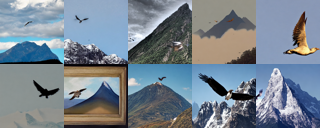

In [11]:
img_list = pipe(["a mountain with a flying bird"]*10, num_inference_steps=25).images
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [10]:
# img_list = pipe(["antique building"]*10, num_inference_steps=25).images
# image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [22]:
del(pipe)
gc.collect()
torch.cuda.empty_cache()

We see that in terms of color and style there is a significant difference between Stable Diffusion direct generated images and the actual EuroSAT dataset images

## Fine-tune Stable Diffusion with LORA and DreamBooth
We want to fine-tune our text-to-image model to learn how to generate the right type of satellite images. To do so, we utilize two recent innovations, Dreambooth and LoRA. Dreambooth is a new method to allow models to learn to generate images that fit the distinct characteristics of the `instance` relative to the larger `class`. Low rank adapters (LoRA) allows for fast model training by drastically reducing the number of training parameters. We utilize the scripts found [here](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md).

To enable Stable Diffusion to learn a new `instance`, we use a unique (and short) token/word to represent the new `instance`. In our case, we use the token/word `sks` that is commonly used, and is not close in terms of character sequence to other meaningful words. `sks` is commonly used in many tutorials for Stable Diffusion fine-tuning.

We first install diffusers library

Next, we run the fine-tuning code. This runs fine-tuning locally within the instance of the notebook. The [accelerate](https://github.com/huggingface/accelerate) library makes running the PyTorch code on multi-GPU easy.

## Visualizing results
Now that the model is trained, let's compare:
1. Stable Diffusion generated images without fine-tuning
2. Stable Diffusion generated images with LoRA and Dreambooth fine-tuning
3. Original EuroSAT images

That's it! This finishes the notebook. In this notebook, we have seen how fine-tuning stable diffusion with custom images increases the quality of generated images. 

## Cleanup
After you close the notebook, please ensure that you close the instance as well using the icon (black square within white circle) on the left.